In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('wustl_iiot_2021.csv')

In [3]:
import os
import random
import tensorflow as tf
from tensorflow.keras import backend as K

# Set a global seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable deterministic ops
os.environ['TF_DETERMINISTIC_OPS'] = '1'


In [4]:
import socket
import struct
import pandas as pd
import re

# Sample IP validation function (IPv4)
def is_valid_ipv4(ip):
    pattern = re.compile(r'^(\d{1,3}\.){3}\d{1,3}$')
    return pattern.match(ip) is not None

# Function to convert IP to integer
def ip_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

# Replace `df` with your actual dataframe
df = df[df['SrcAddr'].apply(is_valid_ipv4)]
df = df[df['DstAddr'].apply(is_valid_ipv4)]

# Convert IP addresses to integers
df['SrcAddr'] = df['SrcAddr'].apply(ip_to_int)
df['DstAddr'] = df['DstAddr'].apply(ip_to_int)


In [5]:
# Select only the required features
features = ['SrcAddr', 'DstAddr', 'Dur', 'TotPkts', 'TotBytes', 'SrcJitter', 'DstJitter', 'Proto']
df = df[features + ['Target']] 


In [6]:
df

,SrcAddr,DstAddr,Dur,TotPkts,TotBytes,SrcJitter,DstJitter,Proto,Target
0,3232235540,3232235522,0.053037,18,1152,527.431726,11.523097,6,0
1,3232235540,3232235522,0.052681,18,1152,17.234379,13.246678,6,0
2,3232235540,3232235522,0.051793,18,1152,522.987240,12.307223,6,0
3,3522227036,3232235522,0.889555,4,248,419.338813,0.000000,6,1
4,3232235540,3232235521,3.500055,14,868,525.146562,0.000000,2054,0
...,...,...,...,...,...,...,...,...,...
1194459,3232235540,3232235522,0.053972,18,1152,521.929056,11.705428,6,0
1194460,3232235540,3232235522,0.032614,12,782,10.769239,8.082586,6,0
1194461,3232235540,3232235522,0.052755,18,1152,519.577053,11.871146,6,0
1194462,3232235540,3232235522,0.051783,18,1152,524.425454,13.780560,6,0


In [7]:
#Separate features and target
X = df.drop('Target', axis=1)
y = df['Target'].values

In [8]:
# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
#Convert scaled X into a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Add Target column
X_scaled_df['Target'] = y

#Save to CSV
X_scaled_df.to_csv("preprocessed_iiot_data.csv", index=False)

In [10]:
#Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# Final Output Summary
print("Preprocessing complete")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Preprocessing complete
X_train shape: (952656, 8)
X_test shape: (238165, 8)
y_train shape: (952656,)
y_test shape: (238165,)


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping


# Use only normal traffic for training
X_train_normal = X_train[y_train == 0]

#  autoencoder
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(decoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the autoencoder
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1, callbacks = [early_stopping])

Epoch 1/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.0139 - val_loss: 1.2721e-04
Epoch 2/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 6.9621e-05 - val_loss: 7.4786e-05
Epoch 3/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 2.5798e-05 - val_loss: 1.5127e-05
Epoch 4/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1.3295e-05 - val_loss: 9.3162e-06
Epoch 5/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1.0587e-04 - val_loss: 5.1659e-04
Epoch 6/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1.6189e-04 - val_loss: 1.1324e-05
Epoch 7/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1.2098e-05 - val_loss: 5.3039e-06
Epoch 8/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 4.8314e-06 - val_loss: 4.0729e-06
Epoch 9/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 8.5632e-06 - val_loss: 4.2725e-05
Epoch 10/100
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 2.4812e-05 - val_loss: 7.8216e-06
Epoch 11/100
3105/3105 

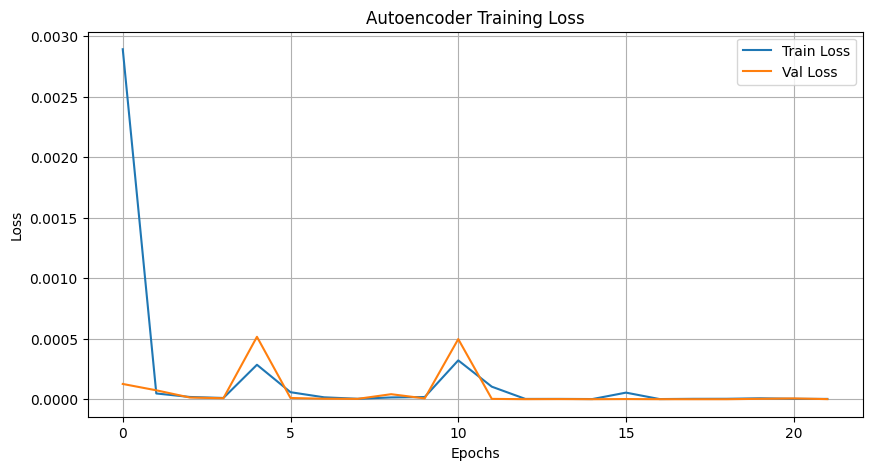

In [13]:
#  Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Predict & Error
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)

7443/7443 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


In [15]:
#Threshold & Prediction
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)


In [16]:
# Evaluation
print("Threshold:", threshold)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


Threshold: 0.0008523622593966673

Confusion Matrix:
 [[220727     35]
 [  5543  11860]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9755    0.9998    0.9875    220762
           1     0.9971    0.6815    0.8096     17403

    accuracy                         0.9766    238165
   macro avg     0.9863    0.8407    0.8986    238165
weighted avg     0.9771    0.9766    0.9745    238165



AUC-ROC Score: 0.9959


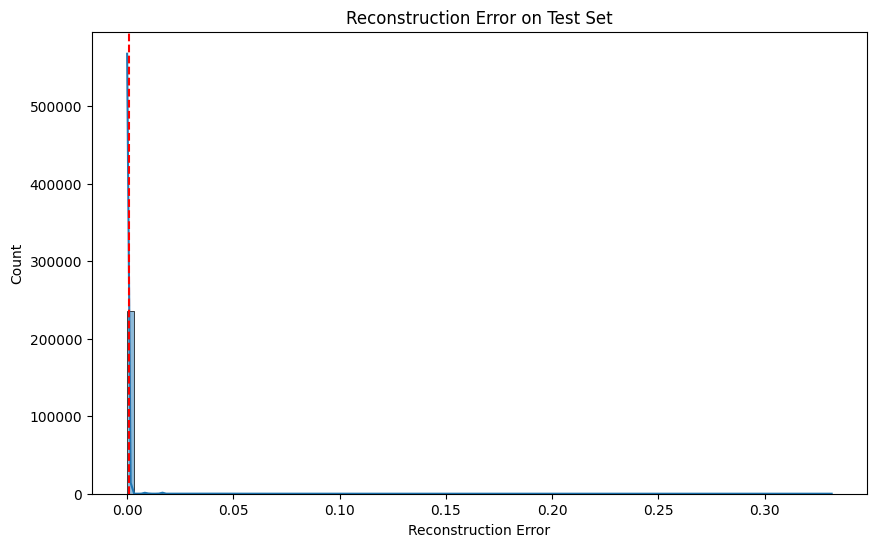

In [17]:
# AUC Score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, reconstruction_error)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error, bins=100, kde=True)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Reconstruction Error on Test Set")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()


In [18]:
from sklearn.ensemble import IsolationForest
#Isolation Forest on reconstruction error

error_df = pd.DataFrame({'reconstruction_error': reconstruction_error})

# Fit Isolation Forest on the reconstruction errors
iso_forest = IsolationForest(contamination=0.07, random_state=SEED)
iso_forest.fit(error_df)

# Predict anomalies: -1 → anomaly, 1 → normal
iso_preds = iso_forest.predict(error_df)
iso_preds = np.where(iso_preds == -1, 1, 0)  # 1: anomaly, 0: normal

# Evaluating Isolation Forest performance
print("\n[Isolation Forest] Confusion Matrix:\n", confusion_matrix(y_test, iso_preds))
print("\n[Isolation Forest] Classification Report:\n", classification_report(y_test, iso_preds, digits=4))



[Isolation Forest] Confusion Matrix:
 [[218300   2462]
 [  3195  14208]]

[Isolation Forest] Classification Report:
               precision    recall  f1-score   support

           0     0.9856    0.9888    0.9872    220762
           1     0.8523    0.8164    0.8340     17403

    accuracy                         0.9762    238165
   macro avg     0.9189    0.9026    0.9106    238165
weighted avg     0.9758    0.9762    0.9760    238165




[XGBoost] Confusion Matrix:
 [[43675   426]
 [  284  3248]]

[XGBoost] Classification Report:
               precision    recall  f1-score   support

           0     0.9935    0.9903    0.9919     44101
           1     0.8841    0.9196    0.9015      3532

    accuracy                         0.9851     47633
   macro avg     0.9388    0.9550    0.9467     47633
weighted avg     0.9854    0.9851    0.9852     47633


[XGBoost] Accuracy Score: 0.9851


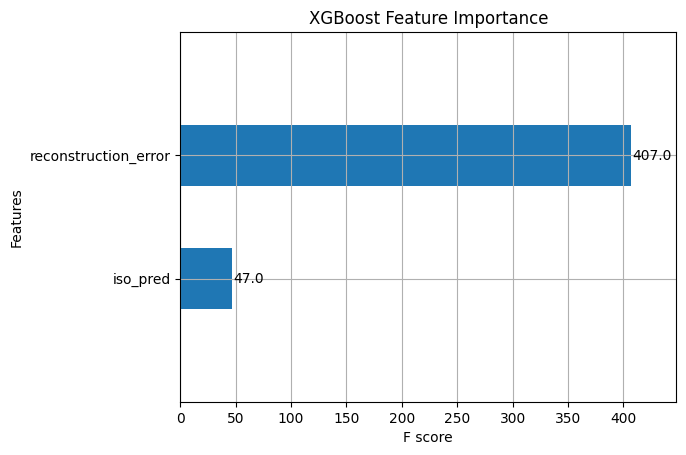

In [29]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Prepare data for XGB
# Combine features: reconstruction error + Isolation Forest predictions
xgb_features = pd.DataFrame({
    'reconstruction_error': reconstruction_error,
    'iso_pred': iso_preds})

# Target: actual test labels
xgb_labels = y_test  # Already available

# Split into train and test (80-20)
X_xgb_train, X_xgb_val, y_xgb_train, y_xgb_val = train_test_split(xgb_features, xgb_labels, test_size=0.2, random_state=SEED)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=SEED)

xgb_model.fit(X_xgb_train, y_xgb_train)

# Evaluate XGBoost

xgb_preds = xgb_model.predict(X_xgb_val)

print("\n[XGBoost] Confusion Matrix:\n", confusion_matrix(y_xgb_val, xgb_preds))
print("\n[XGBoost] Classification Report:\n", classification_report(y_xgb_val, xgb_preds, digits=4))
print("\n[XGBoost] Accuracy Score: {:.4f}".format(accuracy_score(y_xgb_val, xgb_preds)))


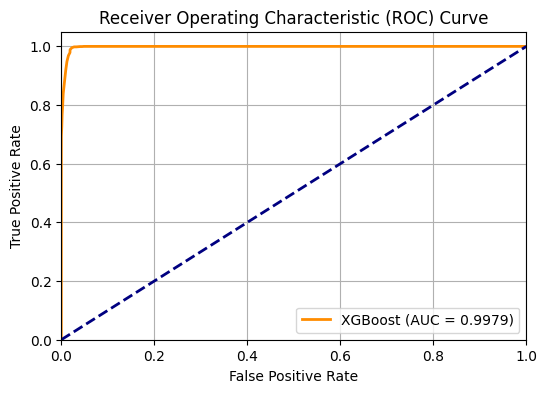

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
xgb_probs = xgb_model.predict_proba(X_xgb_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_xgb_val, xgb_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='XGBoost (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()



[XGBoost - Full Data] Confusion Matrix:
 [[218681   2081]
 [  1312  16091]]

[XGBoost - Full Data] Classification Report:
               precision    recall  f1-score   support

           0     0.9940    0.9906    0.9923    220762
           1     0.8855    0.9246    0.9046     17403

    accuracy                         0.9858    238165
   macro avg     0.9398    0.9576    0.9485    238165
weighted avg     0.9861    0.9858    0.9859    238165



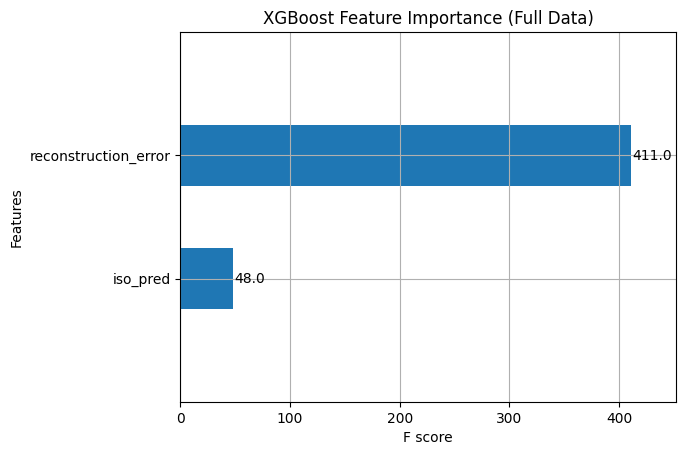

In [20]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report

# Combine features: reconstruction error + Isolation Forest predictions
xgb_features = pd.DataFrame({
    'reconstruction_error': reconstruction_error,
    'iso_pred': iso_preds})

# Target labels
xgb_labels = y_test  # Already complete

# Train on full data
xgb_model_full = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=SEED
)

xgb_model_full.fit(xgb_features, xgb_labels)

# Predict on same full data
xgb_preds_full = xgb_model_full.predict(xgb_features)

# Evaluation
print("\n[XGBoost - Full Data] Confusion Matrix:\n", confusion_matrix(xgb_labels, xgb_preds_full))
print("\n[XGBoost - Full Data] Classification Report:\n", classification_report(xgb_labels, xgb_preds_full, digits=4))


In [21]:
import os              #model dictionary
os.makedirs("model", exist_ok=True)


In [22]:
import joblib
from tensorflow.keras.models import load_model

In [23]:
#Save Autoencoder
autoencoder.save("model/autoencoder_model.h5")


In [24]:
# Isolation Forest
joblib.dump(iso_forest, "model/isolation_forest_model.pkl")


['model/isolation_forest_model.pkl']

In [25]:
#Save XGBoost model
joblib.dump(xgb_model, "model/xgboost_model.pkl")


['model/xgboost_model.pkl']

In [26]:
#Save Scaler
joblib.dump(scaler, "model/scaler.pkl")


['model/scaler.pkl']

In [27]:
print(os.getcwd())
print(os.listdir('model'))

C:\Users\DELL\BASE_MODEL
['autoencoder_model.h5', 'isolation_forest_model.pkl', 'scaler.pkl', 'xgboost_model.pkl']
